In [54]:
import pandas as pd
import numpy as np
import arviz as az

In [55]:
df_brazil = pd.read_excel(r'alldatasets.xlsx',sheet_name='Brazil')

In [56]:
df_brazil.head()

,childid,country,height,stunting_2cat,EDUYRS2,z_score,agegapr1,momeduyrsr1,chsexr1,agemonr1,hhsizer1,wi_newr1,job_cat,pvt_sector,earn_usd
0,BR0,Brazil,180.65,0.0,13.0,1.510429,7.0,8.0,1.0,47.0,4.0,0.882373,3.0,0.0,707.225360
1,BR1,Brazil,180.35,0.0,16.0,0.399053,0.0,5.0,1.0,50.0,3.0,0.306352,3.0,1.0,290.316010
2,BR2,Brazil,164.95,0.0,15.0,0.002132,NaN,5.0,0.0,52.0,3.0,0.533106,3.0,1.0,109.973544
3,BR3,Brazil,182.30,0.0,4.0,-1.823701,NaN,9.0,1.0,49.0,8.0,0.777917,NaN,NaN,0.000000
4,BR4,Brazil,NaN,NaN,NaN,NaN,NaN,15.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
df_brazil.columns

Index(['childid', 'country', 'height', 'stunting_2cat', 'EDUYRS2', 'z_score',
       'agegapr1', 'momeduyrsr1', 'chsexr1', 'agemonr1', 'hhsizer1',
       'wi_newr1', 'job_cat', 'pvt_sector', 'earn_usd'],
      dtype='object')

In [58]:
from scipy import stats
import scipy.stats as stats

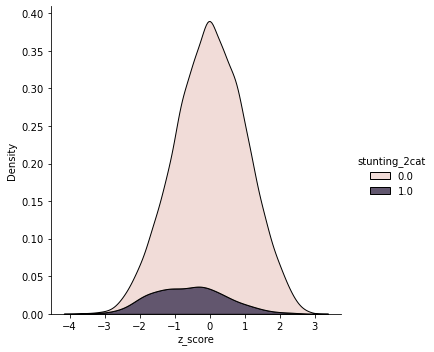

In [59]:
import seaborn as sns
sns.displot(df_brazil, x="z_score", hue="stunting_2cat", kind="kde", multiple="stack")

In [60]:
df_brazil=df_brazil.astype({"chsexr1": 'object', "job_cat": 'object', "pvt_sector": 'object',"stunting_2cat": 'object'})

In [61]:
df_outlier=df_brazil.copy()

In [62]:
total = df_outlier.isnull().sum().sort_values(ascending=False)
percent = (df_outlier.isnull().sum()/df_outlier.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Missing Percent'])
missing_data['Missing Percent'] = missing_data['Missing Percent'].apply(lambda x: x * 100)
missing_data.loc[missing_data['Missing Percent'] > 95]

,Total,Missing Percent


In [63]:
df_outlier=df_outlier.select_dtypes(include=['int64','floating'])

In [64]:
df_outlier.dtypes

height         float64
EDUYRS2        float64
z_score        float64
agegapr1       float64
momeduyrsr1    float64
agemonr1       float64
hhsizer1       float64
wi_newr1       float64
earn_usd       float64
dtype: object

In [65]:
import warnings

warnings.filterwarnings('ignore')

In [66]:
df_outlier.dtypes

height         float64
EDUYRS2        float64
z_score        float64
agegapr1       float64
momeduyrsr1    float64
agemonr1       float64
hhsizer1       float64
wi_newr1       float64
earn_usd       float64
dtype: object

In [67]:
def cap_data(df):
    for col in df.columns:
        print("capping the ",col)
        if (((df[col].dtype)=='float64') | ((df[col].dtype)=='int64') | ((df[col].dtype)=='float32')):
            percentiles = df[col].quantile([0.01,0.99]).values
            df[col][df[col] <= percentiles[0]] = percentiles[0]
            df[col][df[col] >= percentiles[1]] = percentiles[1]
        else:
            df[col]=df[col]
    return df



In [68]:
final_df=cap_data(df_outlier)

capping the  height
capping the  EDUYRS2
capping the  z_score
capping the  agegapr1
capping the  momeduyrsr1
capping the  agemonr1
capping the  hhsizer1
capping the  wi_newr1
capping the  earn_usd


In [69]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler

In [70]:
df_brazil=df_brazil.drop(['childid','country'],axis=1)

In [71]:
all_category_features=df_brazil.select_dtypes(include='object')

In [72]:
all_category_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5914 entries, 0 to 5913
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   stunting_2cat  4742 non-null   object
 1   chsexr1        5913 non-null   object
 2   job_cat        3017 non-null   object
 3   pvt_sector     2766 non-null   object
dtypes: object(4)
memory usage: 184.9+ KB


# KNN for Categories

In [73]:
mm = MinMaxScaler()

def find_category_mappings(df, variable):
    return {k: i for i, k in enumerate(df[variable].dropna().unique(), 0)}

def integer_encode(df , variable, ordinal_mapping):
    df[variable] = df[variable].map(ordinal_mapping)

mappin = dict()
def imputation(df1 , cols):
    df = df1.copy()
    #Encoding dict &amp; Removing nan    
    #mappin = dict()
    for variable in cols:
        mappings = find_category_mappings(df, variable)
        mappin[variable] = mappings

    #Apply mapping
    for variable in cols:
        integer_encode(df, variable, mappin[variable])  

    #Minmaxscaler and KNN imputation 
    sca = mm.fit_transform(df)
    knn_imputer = KNNImputer()
    knn = knn_imputer.fit_transform(sca)
    df.iloc[:,:] = mm.inverse_transform(knn)
    for i in df.columns : 
        df[i] = round(df[i]).astype('int')

    #Inverse transform
    for i in cols:
        inv_map = {v: k for k, v in mappin[i].items()}
        df[i] = df[i].map(inv_map)
    return df

In [74]:
df_cat_imp=imputation(all_category_features,['stunting_2cat','chsexr1','job_cat','pvt_sector'])

In [75]:
df_cat_imp.isnull().sum().sort_values(ascending = False)

pvt_sector       0
job_cat          0
chsexr1          0
stunting_2cat    0
dtype: int64

In [76]:
df_cat_imp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5914 entries, 0 to 5913
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   stunting_2cat  5914 non-null   float64
 1   chsexr1        5914 non-null   float64
 2   job_cat        5914 non-null   float64
 3   pvt_sector     5914 non-null   float64
dtypes: float64(4)
memory usage: 184.9 KB


# KNN for numerics

In [77]:
df_knn=final_df.copy()

In [78]:
df_knn.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5914 entries, 0 to 5913
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   height       3607 non-null   float64
 1   EDUYRS2      3635 non-null   float64
 2   z_score      3611 non-null   float64
 3   agegapr1     3469 non-null   float64
 4   momeduyrsr1  5907 non-null   float64
 5   agemonr1     4747 non-null   float64
 6   hhsizer1     5007 non-null   float64
 7   wi_newr1     4990 non-null   float64
 8   earn_usd     3668 non-null   float64
dtypes: float64(9)
memory usage: 416.0 KB


In [79]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors=5)
df_num_imp = pd.DataFrame(imputer.fit_transform(df_knn),columns = df_knn.columns)

In [80]:
df_num_imp.head()

,height,EDUYRS2,z_score,agegapr1,momeduyrsr1,agemonr1,hhsizer1,wi_newr1,earn_usd
0,180.65,13.0,1.510429,7.0,8.0,47.0,4.0,0.882373,707.225360
1,180.35,16.0,0.399053,0.0,5.0,50.0,3.0,0.306352,290.316010
2,164.95,15.0,0.002132,3.2,5.0,50.0,3.0,0.533106,109.973544
3,182.30,4.0,-1.823701,5.0,9.0,49.0,8.0,0.777917,0.000000
4,177.45,16.0,1.081756,6.2,15.0,45.6,3.6,0.677364,432.998727


In [81]:
df_outlier_concat = pd.concat([df_num_imp, df_cat_imp], axis=1)
df_outlier_concat.head()

,height,EDUYRS2,z_score,agegapr1,momeduyrsr1,agemonr1,hhsizer1,wi_newr1,earn_usd,stunting_2cat,chsexr1,job_cat,pvt_sector
0,180.65,13.0,1.510429,7.0,8.0,47.0,4.0,0.882373,707.225360,0.0,1.0,3.0,0.0
1,180.35,16.0,0.399053,0.0,5.0,50.0,3.0,0.306352,290.316010,0.0,1.0,3.0,1.0
2,164.95,15.0,0.002132,3.2,5.0,50.0,3.0,0.533106,109.973544,0.0,0.0,3.0,1.0
3,182.30,4.0,-1.823701,5.0,9.0,49.0,8.0,0.777917,0.000000,0.0,1.0,2.0,1.0
4,177.45,16.0,1.081756,6.2,15.0,45.6,3.6,0.677364,432.998727,0.0,1.0,3.0,1.0


In [82]:
df_outlier_concat=df_outlier_concat.astype({"stunting_2cat": 'int64'})

In [83]:
df_outlier_concat.head()

,height,EDUYRS2,z_score,agegapr1,momeduyrsr1,agemonr1,hhsizer1,wi_newr1,earn_usd,stunting_2cat,chsexr1,job_cat,pvt_sector
0,180.65,13.0,1.510429,7.0,8.0,47.0,4.0,0.882373,707.225360,0,1.0,3.0,0.0
1,180.35,16.0,0.399053,0.0,5.0,50.0,3.0,0.306352,290.316010,0,1.0,3.0,1.0
2,164.95,15.0,0.002132,3.2,5.0,50.0,3.0,0.533106,109.973544,0,0.0,3.0,1.0
3,182.30,4.0,-1.823701,5.0,9.0,49.0,8.0,0.777917,0.000000,0,1.0,2.0,1.0
4,177.45,16.0,1.081756,6.2,15.0,45.6,3.6,0.677364,432.998727,0,1.0,3.0,1.0


In [84]:
df_knn_imp=df_outlier_concat.copy()

# Bayesian

In [85]:
Y = df_knn_imp['z_score']
X = df_knn_imp[['stunting_2cat', 'agegapr1', 'momeduyrsr1', 'chsexr1', 'agemonr1','wi_newr1',
       'hhsizer1']]

In [86]:
import pymc3 as pm

with pm.Model() as linear_model:
    # Intercept
    intercept = pm.Normal('Intercept', mu = 0, sd = 10)
    
    # Slope 
    stunting_2cat = pm.Normal('stunting_2cat', mu = 1, sd = 1)
    agemonr1        = pm.Normal('agemonr1', mu = 1, sd = 1)  
    chsexr1       = pm.Normal('chsexr1', mu = 1, sd = 1)  
    agegapr1        = pm.Normal('agegapr1', mu = 1, sd = 1)   
    momeduyrsr1     = pm.Normal('momeduyrsr1', mu = 1, sd = 1)  
    hhsizer1        = pm.Normal('hhsizer1', mu = 1, sd = 1)  
    wi_newr1        = pm.Normal('wi_newr1', mu = 1, sd = 1)
    
    
    
    # Standard deviation
    sigma = pm.HalfNormal('sigma', sd = 10)
    
    # Estimate of mean
    mean = intercept + stunting_2cat * X.loc[:, 'stunting_2cat'] + agemonr1 * X.loc[:, 'agemonr1'] +     chsexr1 * X.loc[:, 'chsexr1'] +  agegapr1 * X.loc[:, 'agegapr1'] +  momeduyrsr1 * X.loc[:, 'momeduyrsr1']     +  hhsizer1 * X.loc[:, 'hhsizer1'] +  wi_newr1 * X.loc[:, 'wi_newr1'] 


    
    # Observed values
    Y_obs = pm.Normal('Y_obs', mu = mean, sd = sigma, observed = Y.values)
    
    # Sampler
    step = pm.NUTS()

    # Posterior distribution
    linear_trace = pm.sample(14000, step)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, wi_newr1, hhsizer1, momeduyrsr1, agegapr1, chsexr1, agemonr1, stunting_2cat, Intercept]


Sampling 4 chains for 1_000 tune and 14_000 draw iterations (4_000 + 56_000 draws total) took 394 seconds.
The acceptance probability does not match the target. It is 0.8849304540755784, but should be close to 0.8. Try to increase the number of tuning steps.


In [87]:
az.summary(linear_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,-1.456,0.125,-1.683,-1.214,0.001,0.001,27473.0,27463.0,27477.0,32708.0,1.0
stunting_2cat,-0.195,0.034,-0.257,-0.130,0.000,0.000,48454.0,48277.0,48448.0,40014.0,1.0
agemonr1,0.017,0.003,0.012,0.023,0.000,0.000,28213.0,28085.0,28220.0,32932.0,1.0
chsexr1,0.062,0.019,0.027,0.097,0.000,0.000,52935.0,49697.0,52884.0,40783.0,1.0
agegapr1,-0.002,0.003,-0.007,0.003,0.000,0.000,56361.0,38454.0,56367.0,41976.0,1.0
momeduyrsr1,0.077,0.003,0.071,0.082,0.000,0.000,38141.0,38139.0,38136.0,40271.0,1.0
hhsizer1,-0.049,0.006,-0.060,-0.038,0.000,0.000,38835.0,38835.0,38826.0,39710.0,1.0
wi_newr1,0.857,0.063,0.739,0.974,0.000,0.000,35281.0,35281.0,35275.0,38484.0,1.0
sigma,0.711,0.007,0.699,0.723,0.000,0.000,46294.0,46294.0,46299.0,38568.0,1.0


array([[<AxesSubplot:title={'center':'Intercept'}>,
        <AxesSubplot:title={'center':'Intercept'}>],
       [<AxesSubplot:title={'center':'stunting_2cat'}>,
        <AxesSubplot:title={'center':'stunting_2cat'}>],
       [<AxesSubplot:title={'center':'agemonr1'}>,
        <AxesSubplot:title={'center':'agemonr1'}>],
       [<AxesSubplot:title={'center':'chsexr1'}>,
        <AxesSubplot:title={'center':'chsexr1'}>],
       [<AxesSubplot:title={'center':'agegapr1'}>,
        <AxesSubplot:title={'center':'agegapr1'}>],
       [<AxesSubplot:title={'center':'momeduyrsr1'}>,
        <AxesSubplot:title={'center':'momeduyrsr1'}>],
       [<AxesSubplot:title={'center':'hhsizer1'}>,
        <AxesSubplot:title={'center':'hhsizer1'}>],
       [<AxesSubplot:title={'center':'wi_newr1'}>,
        <AxesSubplot:title={'center':'wi_newr1'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

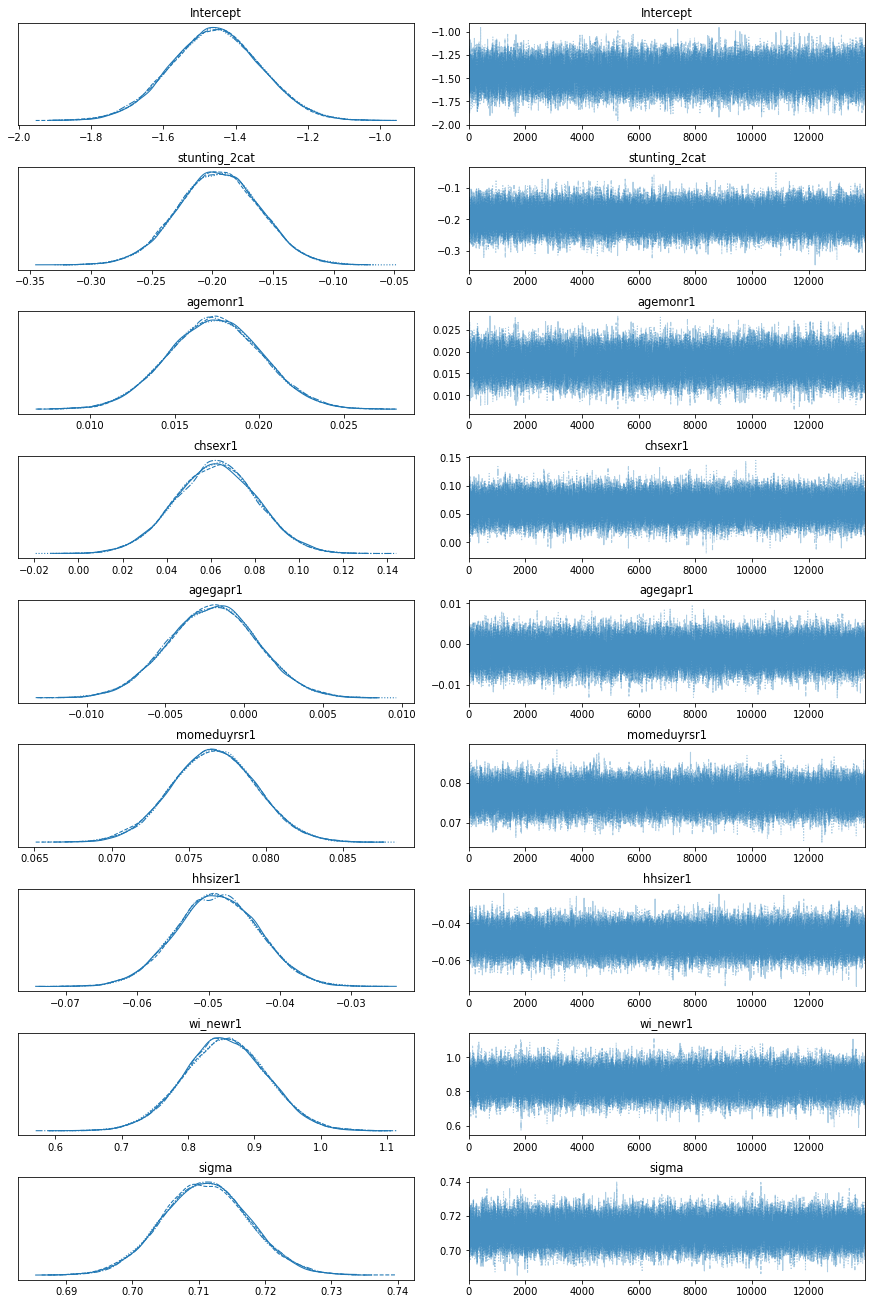

In [88]:
az.plot_trace(linear_trace)

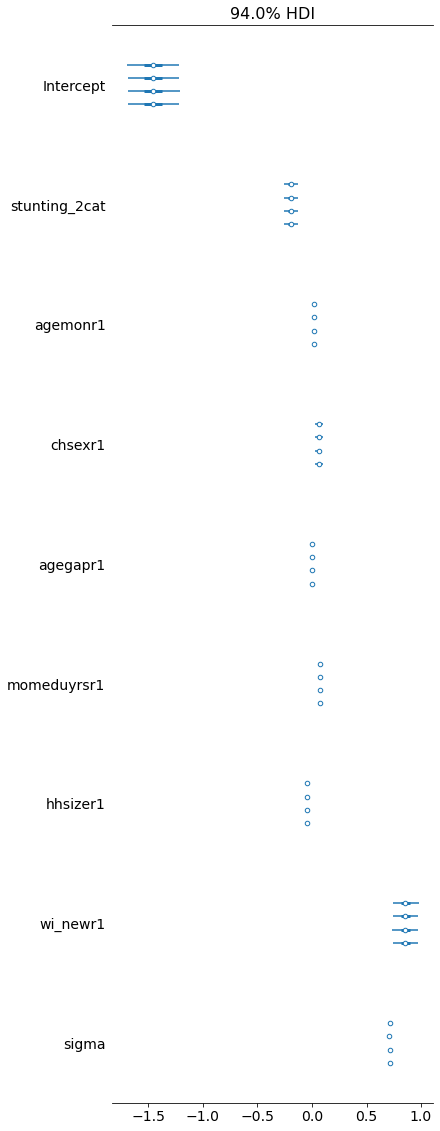

In [89]:
az.plot_forest(linear_trace);